In [10]:
import numpy as np
from CrossSections import Transfer_SigmaV, Normalized_SigmaV, Transfer_sigma, Normalized_Transer, Transfer_Sigma_Low_Energy
from scipy.optimize import minimize
import emcee

### Datos

Datos Camila

In [2]:
CamilaData_Fig7 = np.loadtxt('Data-Sets/Data_Fig7_Correa_2021.txt')
VelocityData = CamilaData_Fig7[:,0]
Velocity_16_Percentile = CamilaData_Fig7[:,1]
Velocity_84_Percentile = CamilaData_Fig7[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig7[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig7[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig7[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


Datos Yu-Tulin

In [3]:
# For the fit
OrderedData = np.loadtxt('Data-Sets/Datos_ordenados.csv')
x_data = OrderedData[:,0]
y_data = OrderedData[:,1]
err_x_data = OrderedData[:,2]
err_y_data = OrderedData[:,3]


### Models

In [3]:


"""
////////////// Functions for the Fit //////////////////
"""
#Useful functions to use emcee
class mcmc_res:
    def __init__(self, sampler, x0=None):
        self.sampler = sampler
        self.flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        self.x = []
        self.x_low = []
        self.x_high = []
        self.ndim = self.flat_samples.shape[1]
        for i in range(self.ndim):
            mcmc = np.percentile(self.flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            self.x.append(mcmc[1])
            self.x_low.append(q[0])
            self.x_high.append(q[1])
        self.x0 = x0
        self.nonmarg_bestfit = sampler.flatchain[np.argmin(sampler.flatlnprobability)]
        
def run_mcmc(func_chi2, x0=None, bounds=None, nstep=5000, args=()):    
    assert x0 is not None, 'please, provide a first guess of the parameter values'
    assert bounds is not None, 'please, provide the boundaries of the parameter hyperspace'    
    def log_prior(theta, bounds):
        theta_l = list(theta)
        for i, pp in enumerate(theta_l):
            if (pp < bounds[i][0]) | (pp > bounds[i][1]):
                return -np.inf
        return 0    
    def log_likelihood(theta, *args):
        return -0.5 * func_chi2(theta, *args)    
    def log_probability(theta, *args):
        lp = log_prior(theta, bounds)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, *args)    
    #import emcee    
    ndim = len(x0)
    nwalkers = 4 * ndim    
    pos = x0 + 1e-4 * np.random.randn(nwalkers, ndim)    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(pos, nstep, progress=True)    
    result = mcmc_res(sampler, x0=x0) 
    # Autocorrelation time
    #tau = sampler.get_autocorr_time()
    #print(tau)
    return result

In [4]:
# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Normalized_SigmaV(x, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x

def compute_particle_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Transfer_SigmaV(x, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x

Some Plots

In [8]:
Transfer_sigma(1)

16.998566386680032

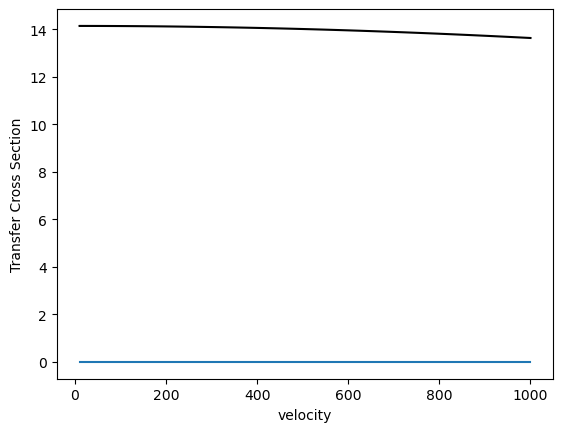

In [12]:
import matplotlib.pyplot as plt


v_array = np.logspace(1, 3, 100)
crossSection_array = [Transfer_Sigma_Low_Energy(v) for v in v_array]
crossSection_array_low = [Transfer_sigma(v) for v in v_array]


plt.plot(v_array, crossSection_array)
plt.plot(v_array, crossSection_array_low, 'k')



plt.xscale('log')
plt.yscale('log')
plt.ylabel('Transfer Cross Section')
plt.xlabel('velocity')
plt.show()


## Fits

### Fits with Camila Data

In [ ]:
data_args = (VelocityData, CrossSectionData, (VelocityData_Err, CrossSectionData_Err))
M_ini, m_ini = 10, 10
initial = [M_ini, m_ini]
bnds= [(0.1, 1000), (.01, 1000)]


bf_Norm = run_mcmc(compute_chi2, x0=initial, bounds=bnds)

bf_Norm.x

import corner

truth = bfY.x
labels = ['M', 'm']
bounds = bnds

figure = corner.corner(
            bfY.flat_samples, labels=labels, title_kwargs={"fontsize": 12}, 
            label_kwargs={"fontsize": 12}, smooth=2, smooth1d=2, truths=truth,
            range=bounds, color='royalblue',
            levels=(0.39,0.68), plot_datapoints=False, show_titles=True
        )

### Fits with Yu Data

def compute_chi2(free_params, x=x_data, data=y_data, err=(err_x_data, err_y_data)):
    #Compute model
    M, m = free_params
    model = [Transfer_SigmaV(x, g=0.1, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x


M_ini, m_ini = 0.01, 100
initial = [M_ini, m_ini]
bnds= [(0.001, 100), (.01, 1000)]


bf2 = run_mcmc(compute_chi2, x0=initial, bounds=bnds)

bf2.x